## Prediction of Alcohol and Flavanoids content  in wine 
The wine dataset - is standard wine dataset used in many tutorials for wine classification. However, in this notebook a new analysis of this dataset is presented, that is not targeting classification, but prediction of alcohol and flavanoids content in wine based on all other attributes.

In [151]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sbr
from matplotlib import pyplot as plt
import timeit


#import sklearn library:
from sklearn import tree
from sklearn import datasets
from sklearn import model_selection
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D as Axes3D
from sklearn.decomposition import PCA
from sklearn import cross_validation
from sklearn.ensemble import AdaBoostClassifier
from sklearn import grid_search
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sfa


In [128]:
# Read dataset, add column names 
data = pd.read_csv("wine.data.txt",names=["Class","Alcohol","Malic Alic","Ash","Alcanility of Ash","Magnesium",
                    "Total phenols","Flavanoids","Nonflavanoid phenols","Proanthocyanins","Color intensity","Hue","OD280_OD315_diluted wines",
                    "Proline"])

## Explore dataset:

In [129]:
# First glance on data:
data.head()

,Class,Alcohol,Malic Alic,Ash,Alcanility of Ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280_OD315_diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


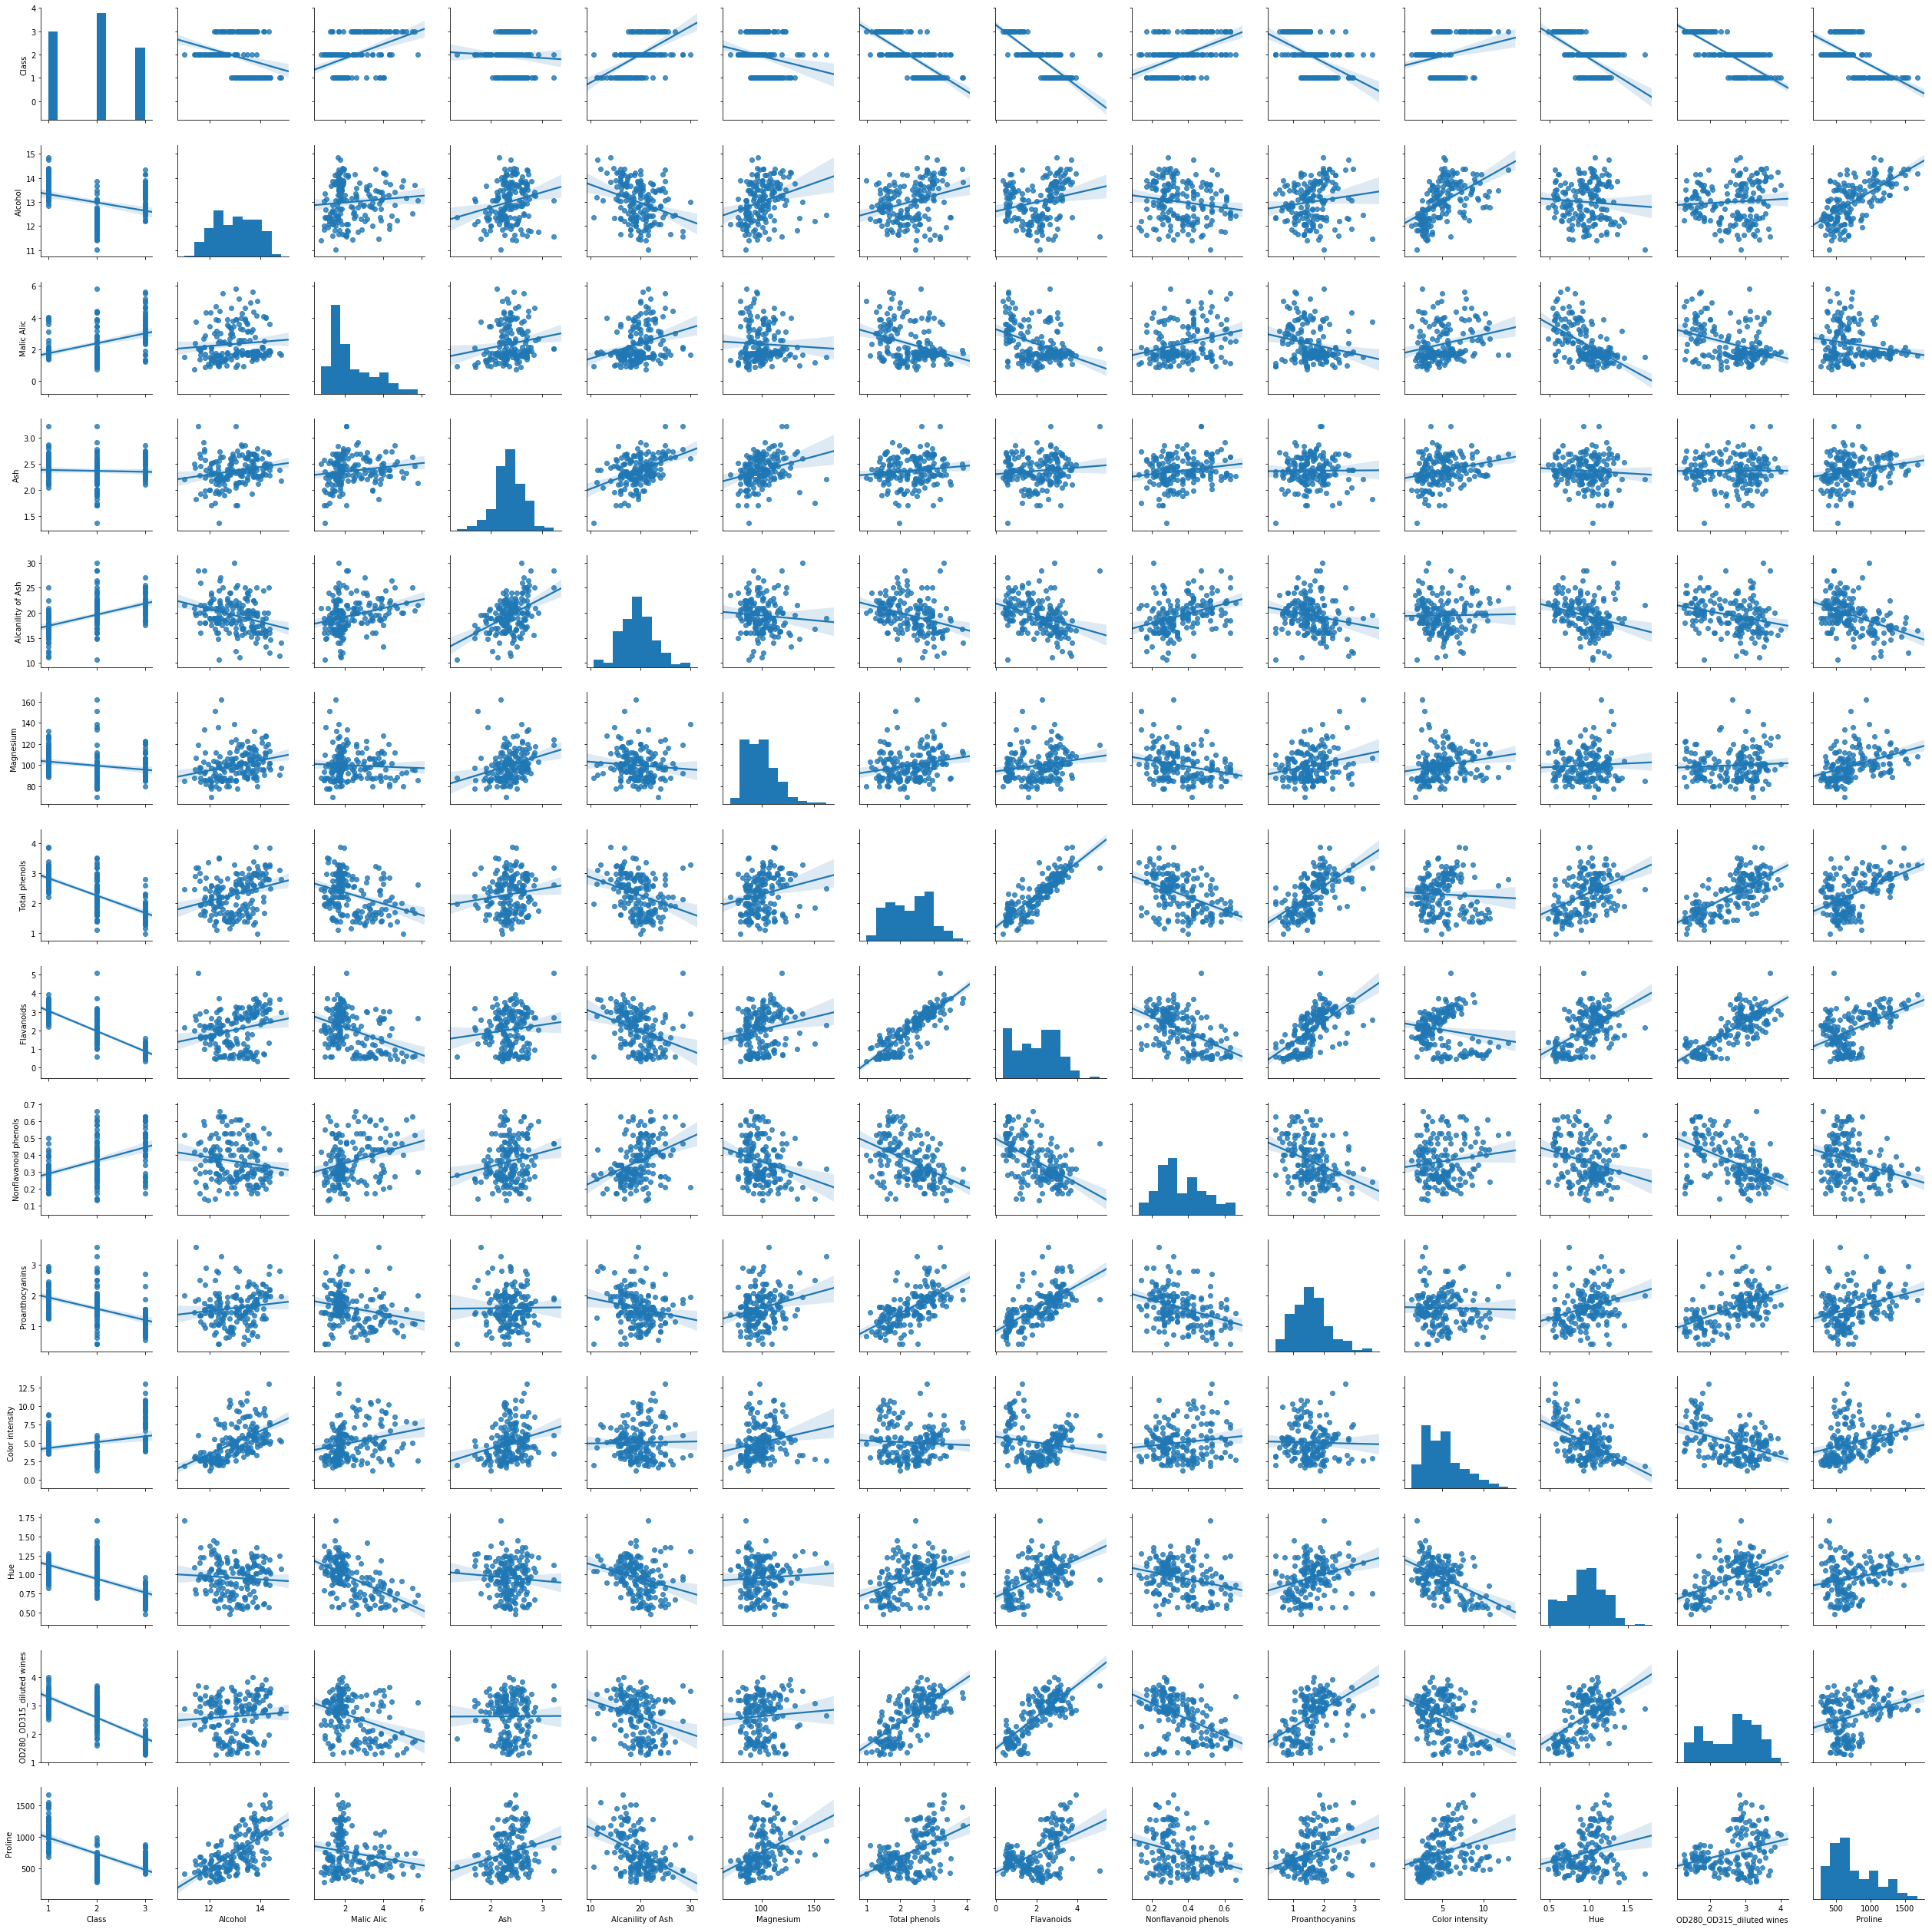

In [130]:
#check all attributes for pairwise dependensies:
sbr.pairplot(data, kind='reg')

From pairplot is can be seen that most promising wine attributes to build successful linear model are Flavanoids and Total Phenols, as they have clear linear dependency with some other attributes.  
However, from practical point of view it is more interesting to see if alcohol content can be predicted by other attributes.  From the first view alchol content has some linear dependency, but not so obvious as flavanoids content.  As further steps, linear model on both Flavanoids and Alcohol content prediction is built and performance of this model for both attributes is compared.    



1. Separate attributes of data set in x1 avs alcohol content in y1, and x2 vs flavanoids content in y2. isualize pairwise comparisson.


In [131]:
#separate attribute alcohol from other attributes and create x1 and y1:
y1 = data["Alcohol"].values.reshape(data.shape[0],1)
x1 = data.loc[:, data.columns != 'Alcohol']

In [132]:
#separate attribute alcohol from other attributes and create x2 and y2:
y2 = data["Flavanoids"].values.reshape(data.shape[0],1)
x2 = data.loc[:, data.columns != 'Flavanoids']

2. Separate pairplots for both variables to visualize dependencies better:

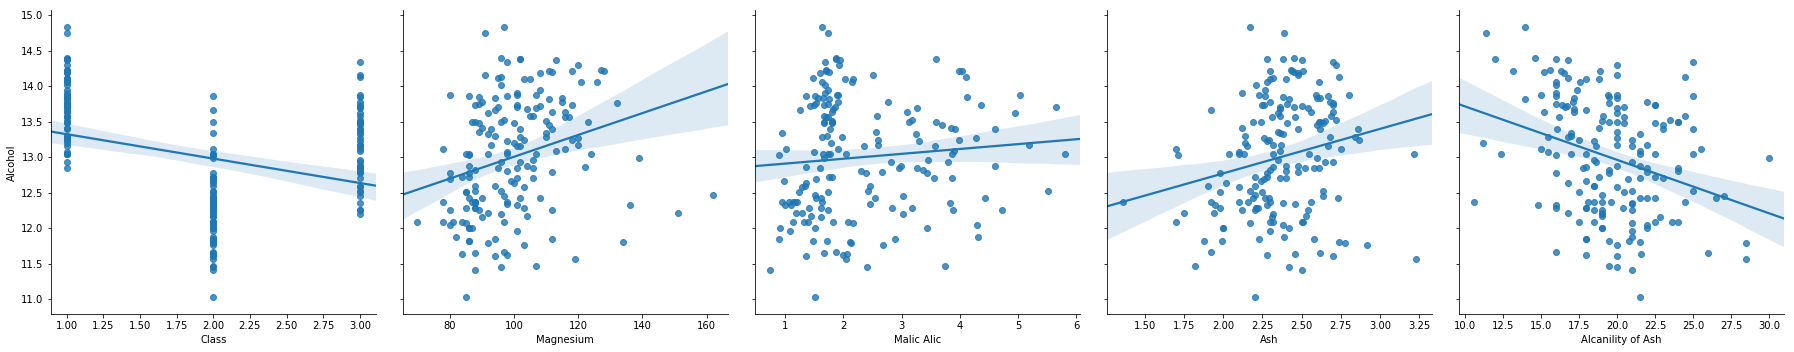

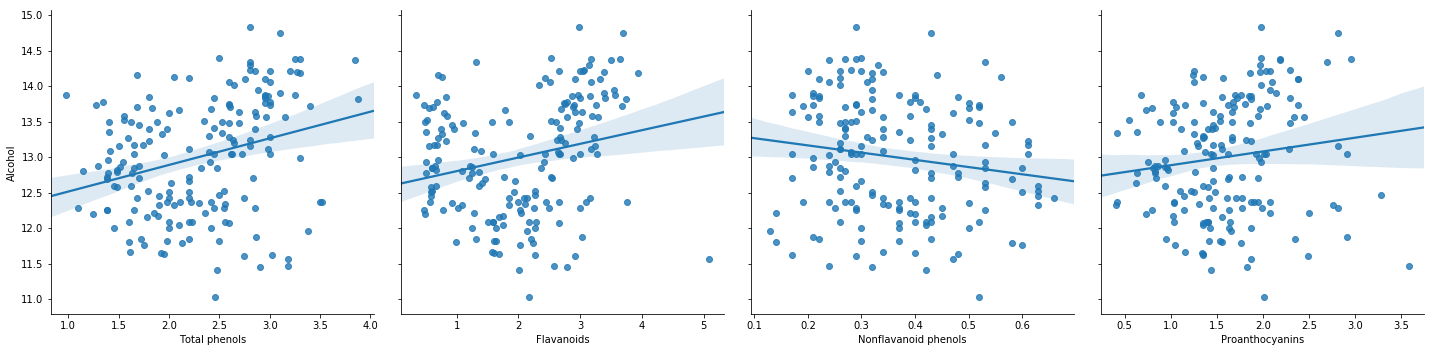

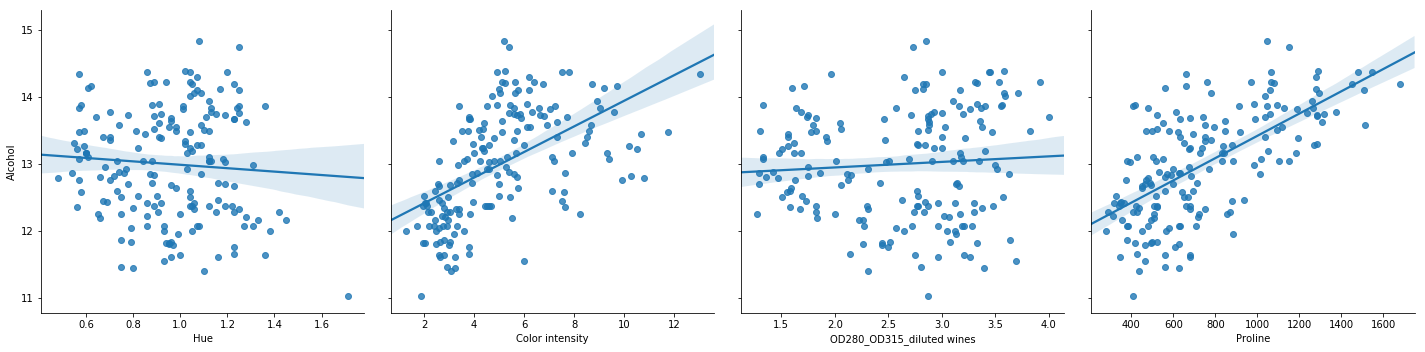

In [133]:
#visualize data pairwise ontent and fit regression line for alcohol:

sbr.pairplot(data, x_vars=["Class","Magnesium","Malic Alic","Ash", "Alcanility of Ash"], 
                           y_vars='Alcohol', size = 5, kind='reg')
                           
sbr.pairplot(data, x_vars=["Total phenols","Flavanoids", "Nonflavanoid phenols","Proanthocyanins"],\
                           y_vars='Alcohol', size = 5, kind='reg')
                
sbr.pairplot(data, x_vars=["Hue","Color intensity", "OD280_OD315_diluted wines", "Proline"],\
                           y_vars='Alcohol', size = 5, kind='reg')

From this graph can be concluded that it is not so easy to build linear regression model to predict alcohol content, and even though some variation can be explained, the model should perform very well.

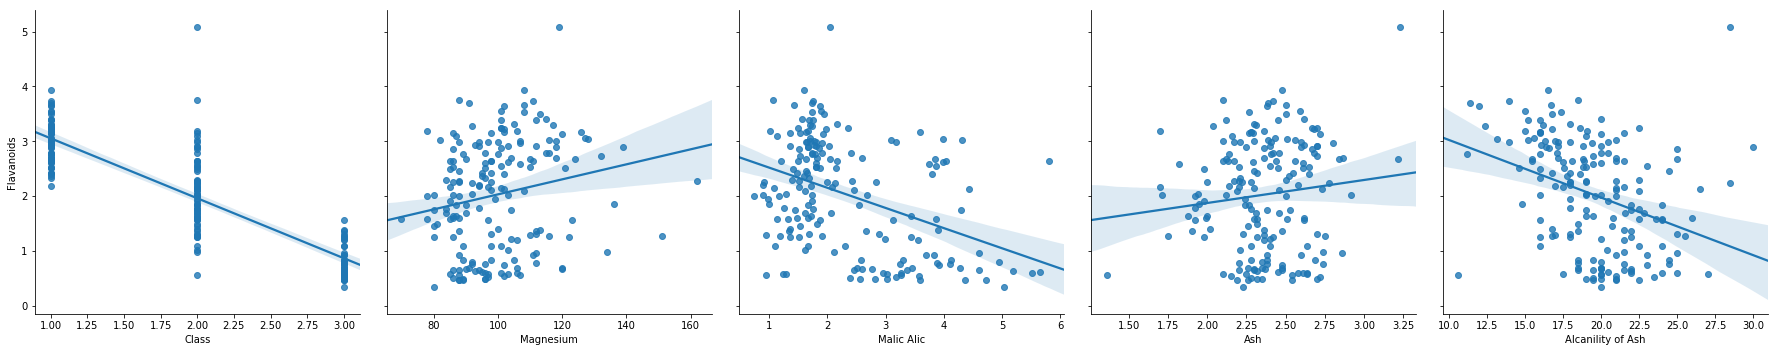

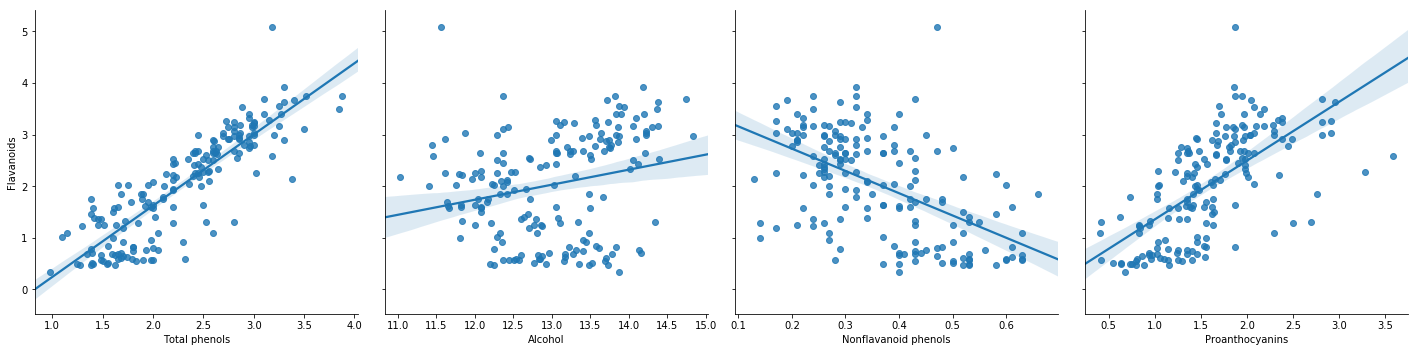

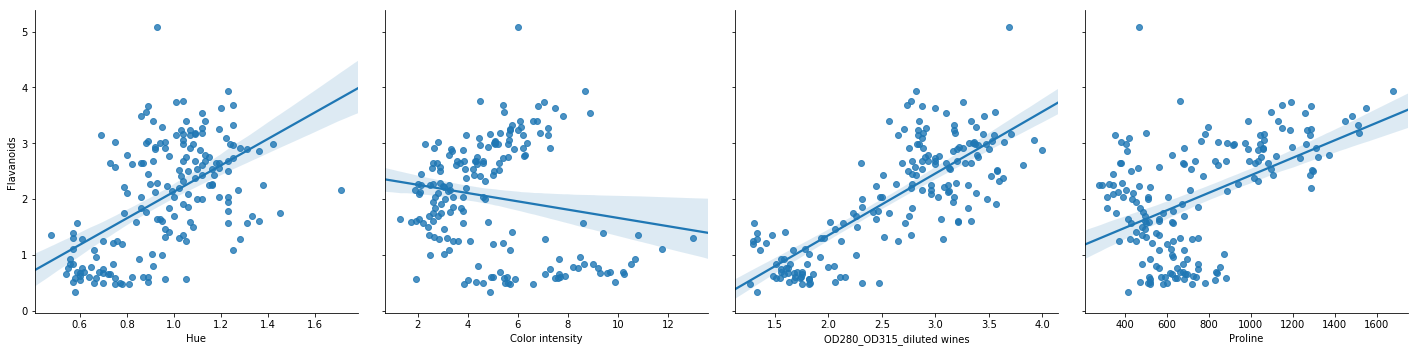

In [134]:
#visualize data pairwise ontent and fit regression line for Flavanoids content:

sbr.pairplot(data, x_vars=["Class","Magnesium","Malic Alic","Ash", "Alcanility of Ash"], 
                           y_vars='Flavanoids', size = 5, kind='reg')
                           
sbr.pairplot(data, x_vars=["Total phenols","Alcohol", "Nonflavanoid phenols","Proanthocyanins"],\
                           y_vars='Flavanoids', size = 5, kind='reg')
                
sbr.pairplot(data, x_vars=["Hue","Color intensity", "OD280_OD315_diluted wines", "Proline"],\
                           y_vars='Flavanoids', size = 5, kind='reg')

From this graph can be concluded that it worth to build linear regression model to predict flavanoids content. Moreover, polynomial regression should fit even better. 

## Step-by-step Linear Regression Model (gradient descent):

(For education purposes I will build step-by-step Linear Regression Model and compare it to SkLearn model)

### Build linear regression from scratch and compare it to sklearn LinearRegression function

In [135]:
## divide dataset into training and test set:

def divide_set (x, y):
    
    # add column with all ones to x - to compensate for W0 and convert x to np.array
    x["w0"] = np.ones([x.shape[0],1]) 
    #normalize datapoints
    x_norm = (x - x.mean(axis = 0))/x.std(axis = 0)
    # add column with all ones to x - to compensate for W0 and convert x to np.array also, convert back class to category
    x_norm["w0"] = np.ones([x.shape[0],1])
    # create array with count from 1 to len(y) and shuffle it:
    idx = np.random.permutation(np.array(range(len(y))))
    n = int(0.8* len(y))
    x_train = x_norm.values[idx[:n]]
    y_train = y[idx[:n]]
    x_test = x_norm.values[idx[n:]]
    y_test = y[idx[n:]]
    return x_train, x_test, y_train, y_test

In [136]:
#initialize weights ():
def initialize (x_train):
    
    w= np.zeros([x_train.shape[1],1]) 
    return w

In [137]:
#forward propagation function:

def forward_prop(x_train, w):
    y_predict = np.dot(x_train,w)
    
    return y_predict

In [138]:
#cost function:

def cost_function(y_train, y_predict):
    
    cost = np.sum(np.square(y_predict - y_train)/(2*len(y_train)))
    
    return cost

In [139]:
# backward propagation function:

def back_prop(w, y_train, y_predict, learning_rate, x_train):
    
    w -= (learning_rate/len(y_train))*np.dot(x_train.T, (y_predict-y_train))
    
    return w
    

### Apply step-by-step Linear Model to predict alcohol content:

time to train model 0.0012916040141135454


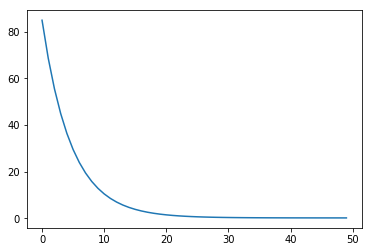

In [200]:
# train model for alcohol content:

iterations = 50
learning_rate = 0.1

# start time counting:
start1 = timeit.default_timer()

x_train1, x_test1, y_train1, y_test1 = divide_set(x1, y1)

start1 = timeit.default_timer()
w1 = initialize(x_train1)
costs1 = []
for i in range(iterations):
        #convert x from dataframe to array
    y_predict1 = forward_prop(x_train1,w1)
    cost1= cost_function(y_train1, y_predict1)
    costs1.append(cost1)
    w1 = back_prop(w1, y_train1, y_predict1, learning_rate, x_train1)
#stop time counting    
stop1 = timeit.default_timer()

print("time to train model", stop1-start1)    

        # plot cost function:      
plt.plot(np.arange(iterations), costs1)

In [201]:
# check accuracy for Alcohol content: 

y_predict1 = forward_prop(x_test1,w1)

error_mean1 = np.sqrt(np.mean(np.square(y_predict1 - y_test1)))
error_std1 = np.sqrt(np.std(np.square(y_predict1 - y_test1))) 


r_value1 = 1 - np.sum(np.square(y_predict1 - y_test1))/np.sum(np.square(y_test1 - np.mean(y_test1)))

print("R^2 score:", r_value1 )
print("Root Mean Squared Error:", error_mean1, "with standard deviation:", error_std1)
print("Intercept:",w1[-1], "Coefficients:", w1[:-1].T)

R^2 score: 0.635135775224439
Root Mean Squared Error: 0.5253592132677172 with standard deviation: 0.6832953844194968
Intercept: [12.92822153] Coefficients: [[-0.13791847  0.20027028  0.02864877 -0.02837149 -0.02093998 -0.07654111
  -0.03600185 -0.0567398  -0.00230312  0.45151541  0.04913154  0.17406507
   0.28268173]]


### Apply step-by-step Linear Model to predict alcohol content:

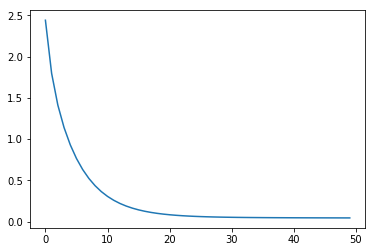

In [173]:
# train model for Flavanoids content:

iterations = 50
learning_rate = 0.1

x_train2, x_test2, y_train2, y_test2 = divide_set(x2, y2)
w2 = initialize(x_train2)
costs2 = []

for i in range(iterations):
        #convert x from dataframe to array
    y_predict2 = forward_prop(x_train2,w2)
    cost2= cost_function(y_train2, y_predict2)
    costs2.append(cost2)
    w2 = back_prop(w2, y_train2, y_predict2, learning_rate, x_train2)

        # plot cost function:      
plt.plot(np.arange(iterations), costs2)

In [174]:
# check accuracy for Alcohol content: 

y_predict2 = forward_prop(x_test2,w2)

error_mean2 = np.sqrt(np.mean(np.square(y_predict2 - y_test2)))
error_std2 = np.sqrt(np.std(np.square(y_predict2 - y_test2))) 


r_value2 = 1 - np.sum(np.square(y_predict2 - y_test2))/np.sum(np.square(y_test2 - np.mean(y_test2)))

print("R^2 score:", r_value2 )
print("Root Mean Squared Error:", error_mean2, "with standard deviation:", error_std2)
print("Intercept:",w2[-1], "Coefficients:", w2[:-1].T)

R^2 score: 0.8017840820990416
Root Mean Squared Error: 0.499799780997775 with standard deviation: 1.004775352230495
Intercept: [1.99322284] Coefficients: [[-0.30748388  0.0325782  -0.02671235  0.06628182  0.00101337 -0.06541903
   0.328558   -0.14132925  0.16874765  0.01399685  0.08723184  0.0875146
  -0.01110617]]


## Modeling with sklearn:

### Linear Regression for alcohol content prediction:

In [202]:
start2 = timeit.default_timer()

linear_reg1 = LinearRegression().fit(x_train1, y_train1)

stop2 = timeit.default_timer()
print("time to train model", stop2-start2) 

print("r^2 score:",linear_reg1.score(x_test1, y_test1))
error_mean_sk1 = np.sqrt(np.mean(np.square(linear_reg1.predict(x_test1) - y_test1)))
error_std_sk1 = np.sqrt(np.std(np.square(linear_reg1.predict(x_test1) - y_test1))) 
print("Root Mean Squared Error:", error_mean_sk1, "with standard deviation:", error_std_sk1)


time to train model 0.0011423939722590148
r^2 score: 0.6694305977397716
Root Mean Squared Error: 0.5000599094368638 with standard deviation: 0.62191300624196


### Linear Regression for flavanoids content prediction:

In [203]:
linear_reg2 = LinearRegression().fit(x_train2, y_train2)
print("r^2 score:",linear_reg2.score(x_test2, y_test2))

error_mean_sk2 = np.sqrt(np.mean(np.square(linear_reg2.predict(x_test2) - y_test2)))
error_std_sk2 = np.sqrt(np.std(np.square(linear_reg2.predict(x_test2) - y_test2))) 
print("Root Mean Squared Error:", error_mean_sk2, "with standard deviation:", error_std_sk2)
print("Intercept:",linear_reg2.intercept_, "Coefficients:",linear_reg2.coef_)

r^2 score: 0.8030652077302419
Root Mean Squared Error: 0.4981819889100983 with standard deviation: 0.9821797652600386
Intercept: [2.004233] Coefficients: [[-0.52032136 -0.01571642  0.00989975  0.05825836  0.02838187 -0.06681175
   0.37363739 -0.16463854  0.14922567  0.0786939   0.10505865 -0.05361063
  -0.1146929   0.        ]]


## Model comparisson:

### 1. Comparison of linear regression model for Flavanoids and Alchohol: 




In [204]:
print("Linear Regression to predict alcohol content")
print("r^2 score:",linear_reg1.score(x_test1, y_test1))
print("Root Mean Squared Error:", error_mean_sk1, "with standard deviation:", error_std_sk1)
print("Alcohol content data mean:",np.mean(data["Alcohol"])," and std:",np.std(data["Alcohol"] ))
print("----------------------------------------------------------------------")

print("Linear Regression to predict flavanoids content")
print("r^2 score:",linear_reg2.score(x_test2, y_test2))
print("Root Mean Squared Error:", error_mean_sk2, "with standard deviation:", error_std_sk2)
print("Flavanoids content data mean:",np.mean(data["Flavanoids"])," and std:",np.std(data["Flavanoids"] ))

Linear Regression to predict alcohol content
r^2 score: 0.6694305977397716
Root Mean Squared Error: 0.5000599094368638 with standard deviation: 0.62191300624196
Alcohol content data mean: 13.000617977528083  and std: 0.809542914528517
----------------------------------------------------------------------
Linear Regression to predict flavanoids content
r^2 score: 0.8030652077302419
Root Mean Squared Error: 0.4981819889100983 with standard deviation: 0.9821797652600386
Flavanoids content data mean: 2.0292696629213474  and std: 0.9960489503792328


It can be seen that for the alcohol model, root mean square error of prediction is approximatelly 0.5 of standard deviation of alcohol content in dataset and linear regression explains around 50% of variation.  
For flavanoids model root mean square error of prediction is approximatelly 0.3 of standard deviation of flavanoids content in dataset and linear regression performs much better - around 80% of variation in data is explained

### 2. Comparison of performance for step-by-step and skLearn linear regression:

In [205]:
print("Step-by-step linear Regression to predict alcohol content")
print("R^2 score:", r_value1 )
print("Root Mean Squared Error:", error_mean1, "with standard deviation:", error_std1)
print("time to train model", stop1-start1) 
print("----------------------------------------------------------------------")
print("SkLearn linear Regression to predict alcohol content")
print("r^2 score:",linear_reg1.score(x_test1, y_test1))
print("Root Mean Squared Error:", error_mean_sk1, "with standard deviation:", error_std_sk1)
print("time to train model", stop2-start2) 

Step-by-step linear Regression to predict alcohol content
R^2 score: 0.635135775224439
Root Mean Squared Error: 0.5253592132677172 with standard deviation: 0.6832953844194968
time to train model 0.0012916040141135454
----------------------------------------------------------------------
SkLearn linear Regression to predict alcohol content
r^2 score: 0.6694305977397716
Root Mean Squared Error: 0.5000599094368638 with standard deviation: 0.62191300624196
time to train model 0.0011423939722590148


Accuracy:  
It can be seen that models perform very similar to each other and it is impossible to say which one is better. To prove this boxplots are made and t-test performed below  
Time:  
Time performance from SkLearn seems to be better. Possibly finding better learning rate and decreasing amount of iterations for step-by-step model could lead to similar performance. But it requres time to tune those parameters. 

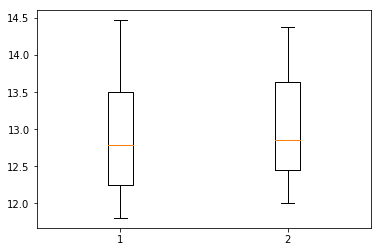

In [208]:
#box-plot for Alcohol content for both models:
plt.boxplot(np.concatenate((y_predict1, linear_reg1.predict(x_test1)), axis =1))
plt.show()

t-test:

Independent t-test: even though datapoins are the same and it can seem that paired t-test should be performed, in this specific case we are more interested to look at total prediction error, rather than checking how different is error for each separate point.
alpha - 0.05
h0: means equal
h1: means are not equal 

In [209]:
t, p = stats.ttest_ind(y_predict1, linear_reg1.predict(x_test1))
print("t = " + str(t))
print("p-value = " + str(p))

t = [-0.89875711]
p-value = [0.37186326]


Acconding to t-test results (p-value>0.05) and boxplots, assumption that means of prediction error sklearn and step-by-step model is confirmed with 95% confidence 